# Notebook 4: Hierarchical Models

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [8]:
# If we're running on Colab, install PyMC and ArviZ
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz

In [9]:
import matplotlib.pyplot as plt

import numpy as np
import pymc3 as pm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [10]:
import pandas as pd

def make_pmf(sample):
    """Make a Series that represents a PMF.
    
    sample: sequence of quantities
    
    returns: Pandas Series
    """
    return pd.Series(sample).value_counts(normalize=True, sort=False).sort_index()

In [11]:
def plot_cdf(sample, **options):
    """Compute and plot the CDF of a sample."""
    pmf = make_pmf(sample)
    cdf = pmf.cumsum()
    plt.plot(cdf.index, cdf.values, **options)

## The Beta Binomial model



In [12]:
with pm.Model() as model:
    
    alpha = pm.Gamma('alpha', alpha=3, beta=1)
    beta = pm.Gamma('beta', alpha=3, beta=1)
        
    x = pm.Beta('x', alpha, beta)
    
    ks = pm.Binomial('ks', n=250, p=x)
    trace = pm.sample_prior_predictive(1000)

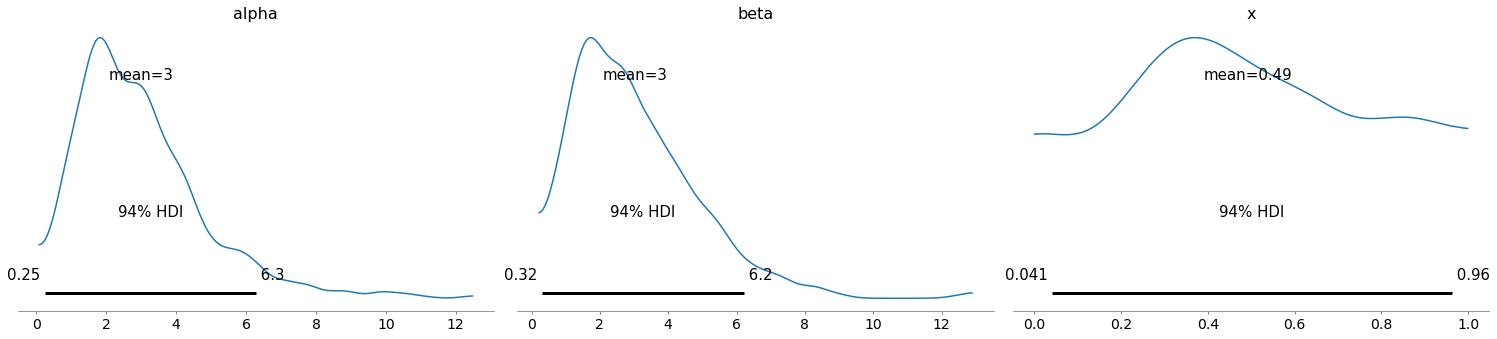

In [13]:
import arviz as az

with model:
    az.plot_posterior(trace, var_names=['alpha', 'beta', 'x'])

In [14]:
data = [140, 130, 120]

with pm.Model() as model:
    
    alpha = pm.Gamma('alpha', alpha=3, beta=1)
    beta = pm.Gamma('beta', alpha=3, beta=1)
        
    xs = pm.Beta('xs', alpha, beta, shape=len(data))
    
    ks = pm.Binomial('ks', n=250, p=xs, observed=data)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xs, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


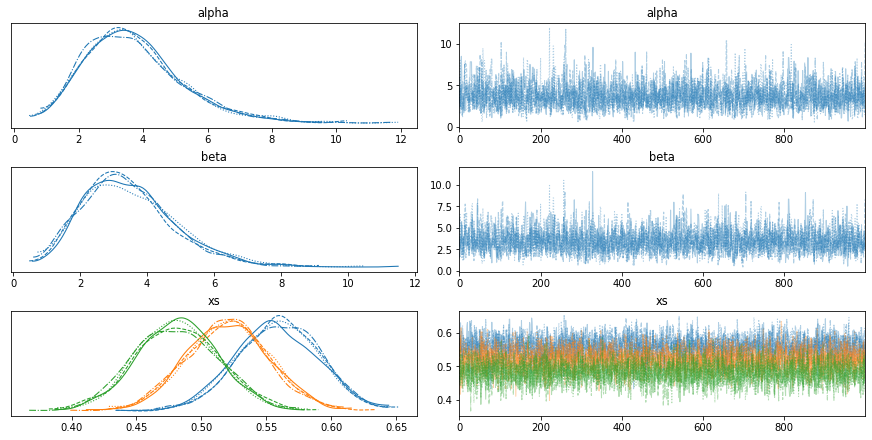

In [15]:
with model:
    az.plot_trace(trace)

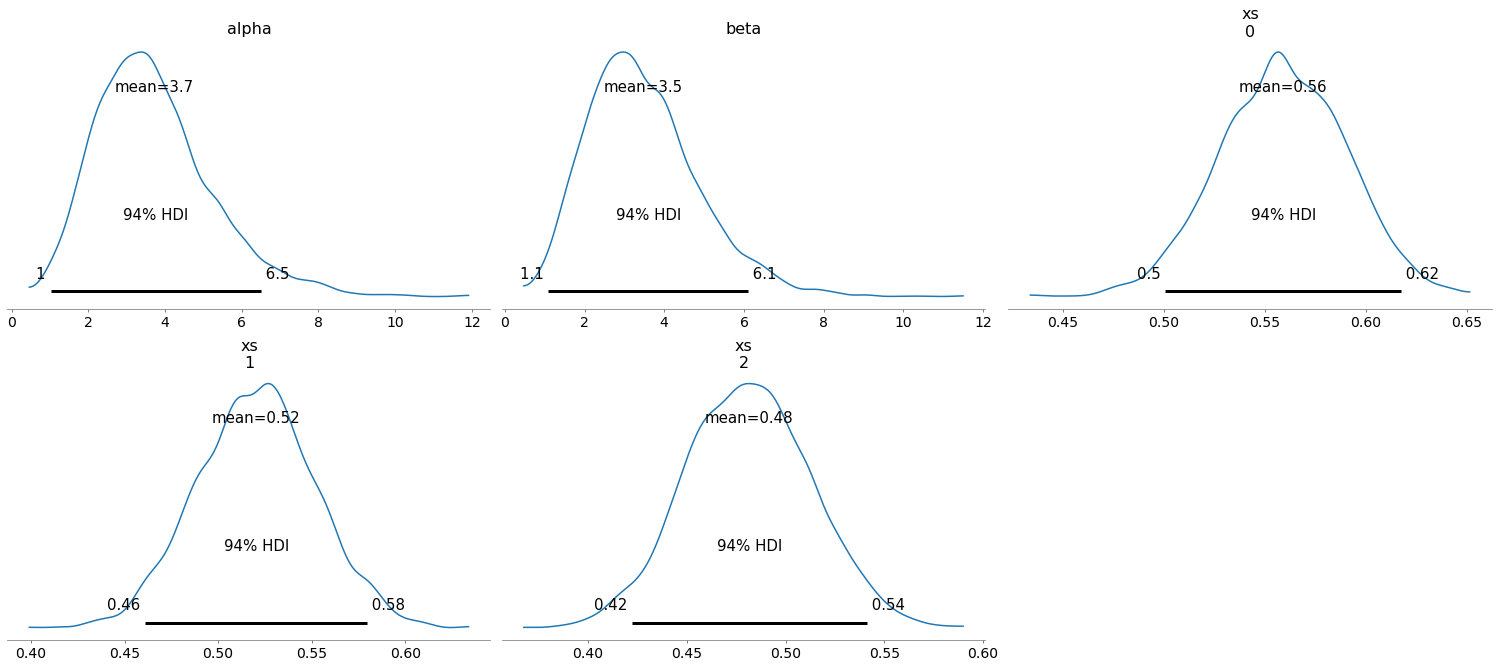

In [16]:
with model:
    az.plot_posterior(trace)

In [17]:
from scipy.stats import beta as beta_dist

alphas = trace['alpha']
betas = trace['beta']
sample_posterior_x = beta_dist.rvs(alphas, betas)
sample_posterior_x.mean()

0.518338127480816

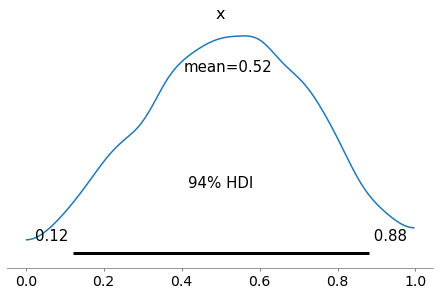

In [18]:
with model:
    az.plot_posterior(sample_posterior_x)

## Heart Attack Data

This examples is based on [Chapter 10 of *Probability and Bayesian Modeling*](https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html#example-deaths-after-heart-attack)

In [ ]:
import os

filename = 'DeathHeartAttackManhattan.csv'
if not os.path.exists(filename):
    !wget 


In [19]:
import pandas as pd

df = pd.read_csv(filename)
df

,Hospital,Cases,Deaths,Death %
0,Bellevue Hospital Center,129,4,3.101
1,Harlem Hospital Center,35,1,2.857
2,Lenox Hill Hospital,228,18,7.894
3,Metropolitan Hospital Center,84,7,8.333
4,Mount Sinai Beth Israel,291,24,8.247
5,Mount Sinai Hospital,270,16,5.926
6,Mount Sinai Roosevelt,46,6,13.043
7,Mount Sinai St. Luke’s,293,19,6.485
8,NYU Hospitals Center,241,15,6.224
9,NYP Hospital - Allen Hospital,105,13,12.381


In [20]:
ns = df['Cases'].values
ns

array([129,  35, 228,  84, 291, 270,  46, 293, 241, 105, 353, 250,  41])

In [21]:
ks = df['Deaths'].values
ks

array([ 4,  1, 18,  7, 24, 16,  6, 19, 15, 13, 25, 11,  4])

In [22]:
data = [140, 130, 120]

with pm.Model() as model:
    
    alpha = pm.Gamma('alpha', alpha=3, beta=1)
    beta = pm.Gamma('beta', alpha=3, beta=1)
        
    xs = pm.Beta('xs', alpha, beta, shape=len(ns))
    
    ks = pm.Binomial('ks', n=ns, p=xs, observed=ks)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xs, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


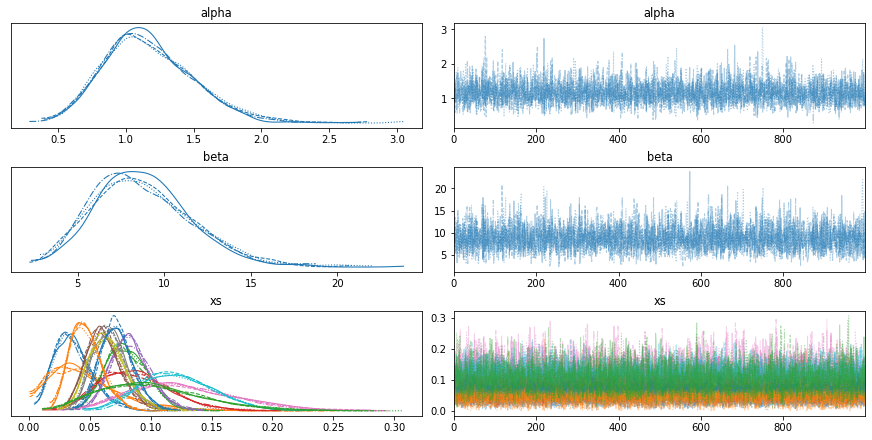

In [24]:
with model:
    az.plot_trace(trace)

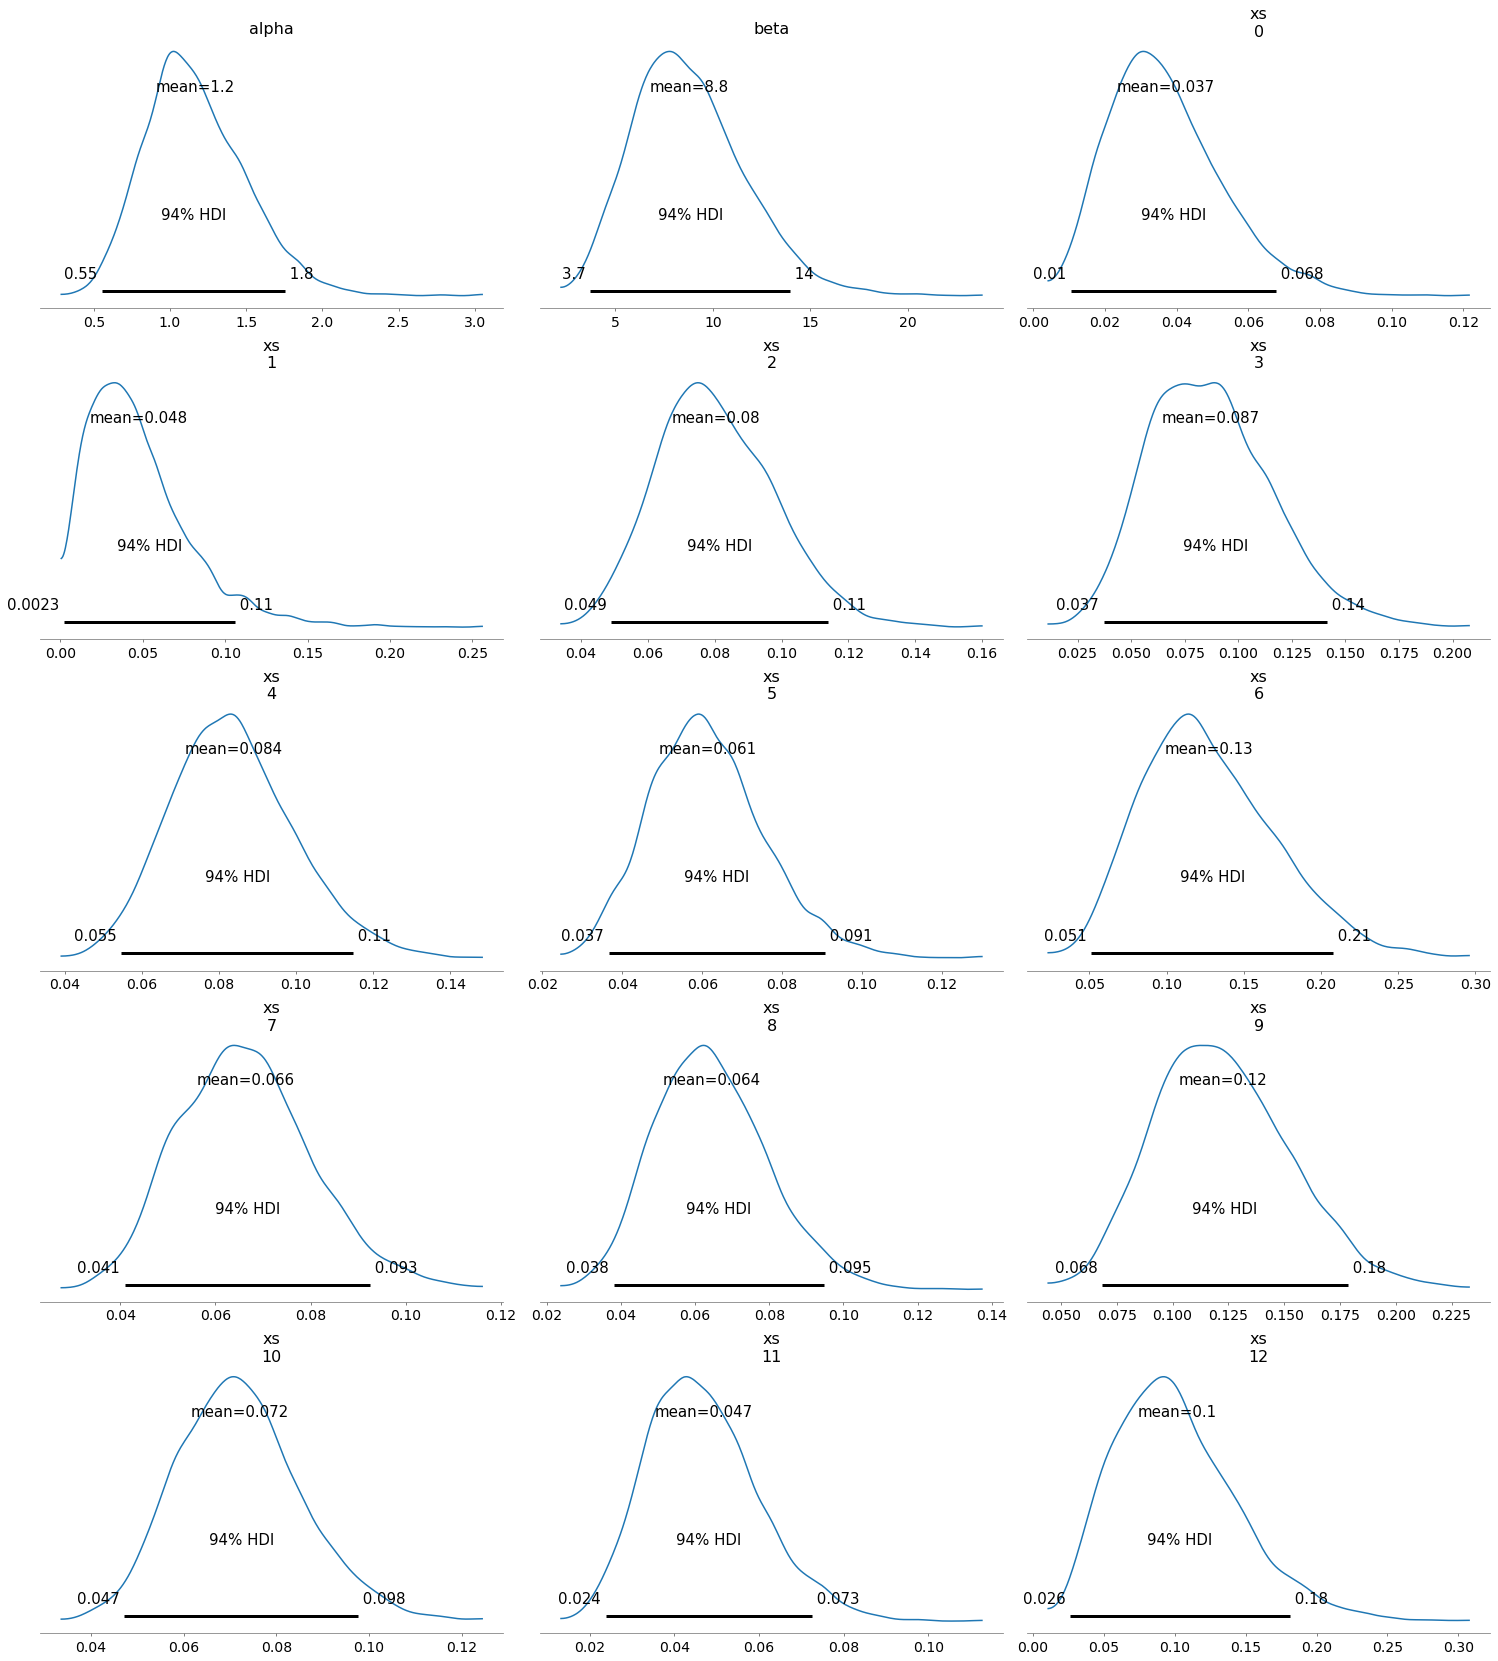

In [26]:
with model:
    az.plot_posterior(trace)

## Poisson model

So far, all of this is based on a gamma prior.  To choose the parameters of the prior, I used data from previous Stanley Cup finals and computed a maximum likelihood estimate (MLE).  But that's not correct, because

1. It assumes that the observed goal counts are the long-term goal-scoring rates.
2. It treats `alpha` and `beta` as known values rather than parameters to estimate.

In other words, I have ignored two important sources of uncertainty.  As a result, my predictions are almost certainly too confident.

The solution is a hierarchical model, where `alpha` and `beta` are the parameters that control `mu` and `mu` is the parameter that controls `goals`.  Then we can use observed `goals` to update the distributions of all three unknown parameters.

Of course, now we need a prior distribution for `alpha` and `beta`.  A common choice is the half Cauchy distribution (see [Gelman](http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf)), but on advice of counsel, I'm going with exponential.

1.0474523093903014

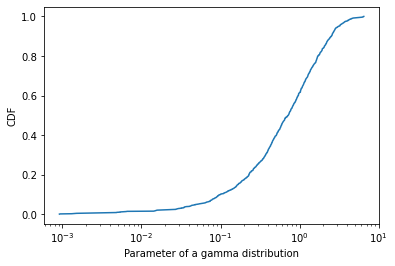

In [17]:
sample = pm.Exponential.dist(lam=1).random(size=1000)
plot_cdf(sample)
plt.xscale('log')
plt.xlabel('Parameter of a gamma distribution')
plt.ylabel('CDF')
np.mean(sample)

This distribution represents radical uncertainty about the value of this distribution: it's probably between 0.1 and 10, but it could be really big or really small.

Here's a PyMC model that generates `alpha` and `beta` from an exponential distribution.

In [18]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    trace = pm.sample_prior_predictive(1000)

Here's what the distributions of `alpha` and `beta` look like.

1.007399528970912

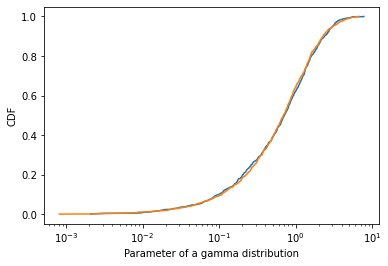

In [19]:
sample_prior_alpha = trace['alpha']
plot_cdf(sample_prior_alpha, label='alpha prior')
sample_prior_beta = trace['beta']
plot_cdf(sample_prior_beta, label='beta prior')

plt.xscale('log')
plt.xlabel('Parameter of a gamma distribution')
plt.ylabel('CDF')
np.mean(sample_prior_alpha)

Now that we have `alpha` and `beta`, we can generate `mu`.

In [20]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    trace = pm.sample_prior_predictive(1000)

/home/downey/anaconda3/envs/BayesianInferencePyMC/lib/python3.9/site-packages/pymc3/distributions/transforms.py:221: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


Here's what the prior distribution of `mu` looks like.

In [22]:
def decorate_rate(ylabel='PDF'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend()

6.635459525581014

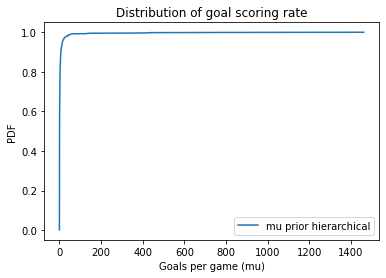

In [23]:
sample_prior_mu = trace['mu']
plot_cdf(sample_prior_mu, label='mu prior hierarchical')
decorate_rate('CDF')
np.mean(sample_prior_mu)

In effect, the model is saying "I have never seen a hockey game before.  As far as I know, it could be soccer, could be basketball, could be pinball."


The hierarchical model admits the possibility that `mu` could be orders of magnitude bigger. Unreasonable as that might seem, it's probably what we want in a non-committal prior.

Last step of the forward process, let's generate some goals.

In [29]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

/home/downey/anaconda3/envs/BayesianInferencePyMC/lib/python3.9/site-packages/pymc3/distributions/transforms.py:221: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


Here's the prior predictive distribution of goals.

In [31]:
def decorate_goals(ylabel='PMF'):
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel(ylabel)
    plt.title('Distribution of goals scored')
    plt.legend()

7.886

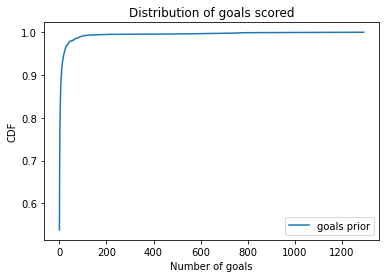

In [32]:
sample_prior_goals = trace['goals']
plot_cdf(sample_prior_goals, label='goals prior')
decorate_goals('CDF')
np.mean(sample_prior_goals)

## Hierarchical inference

Once we have the forward process working, we only need a small change to run the reverse process.

In [34]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=[6])
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


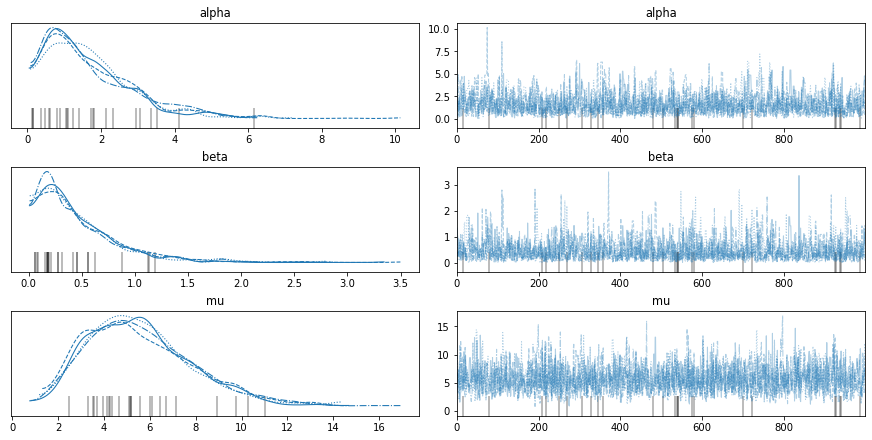

In [36]:
with model:
    az.plot_trace(trace)

Here's the posterior distribution of `mu`.  The posterior mean is close to the observed value, which is what we expect with a weakly informative prior.

5.598512318984647

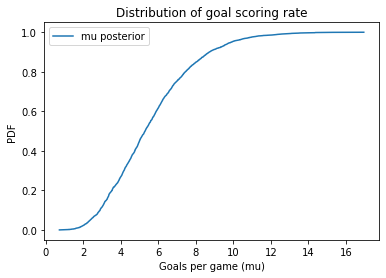

In [38]:
sample_post_mu = trace['mu']
plot_cdf(sample_post_mu, label='mu posterior')
decorate_rate()
np.mean(sample_post_mu)

## Two teams

We can extend the model to estimate different values of `mu` for the two teams.

In [87]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu_VGK = pm.Gamma('mu_VGK', alpha, beta)
    mu_WSH = pm.Gamma('mu_WSH', alpha, beta)
    goals_VGK = pm.Poisson('goals_VGK', mu_VGK, observed=[6])
    goals_WSH = pm.Poisson('goals_WSH', mu_WSH, observed=[4])
    trace = pm.sample(1000, tune=2000, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_WSH, mu_VGK, beta, alpha]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:06<00:00, 941.93draws/s] 


We can use `traceplot` to review the results and do some visual diagnostics.

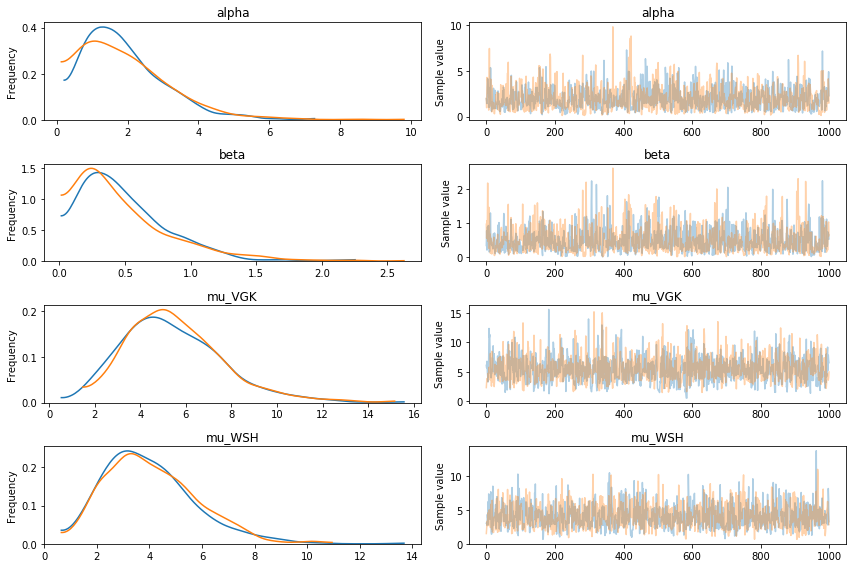

In [88]:
pm.traceplot(trace);

Here are the posterior distribitions for `mu_WSH` and `mu_VGK`.

(4.0273559918578625, 5.458780874512413)

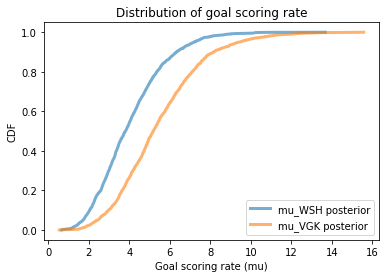

In [89]:
sample_post_mu_WSH = trace['mu_WSH']
plot_cdf(sample_post_mu_WSH, label='mu_WSH posterior')

sample_post_mu_VGK = trace['mu_VGK']
plot_cdf(sample_post_mu_VGK, label='mu_VGK posterior')

cdf_rates()
np.mean(sample_post_mu_WSH), np.mean(sample_post_mu_VGK)

On the basis of one game (and never having seen a previous game), here's the probability that Vegas is the better team.

In [90]:
np.mean(sample_post_mu_VGK > sample_post_mu_WSH)

0.7185

## More background

But let's take advantage of more information.  Here are the results from the five most recent Stanley Cup finals, ignoring games that went into overtime.

In [39]:
data = dict(BOS13 = [2, 1, 2],
            CHI13 = [0, 3, 3],
            NYR14 = [0, 2],
            LAK14 = [3, 1],
            TBL15 = [1, 4, 3, 1, 1, 0],
            CHI15 = [2, 3, 2, 2, 2, 2],
            SJS16 = [2, 1, 4, 1],
            PIT16 = [3, 3, 2, 3],
            NSH17 = [3, 1, 5, 4, 0, 0],
            PIT17 = [5, 4, 1, 1, 6, 2],
            VGK18 = [6,2,1],
            WSH18 = [4,3,3],
           )

Here's how we can get the data into the model.

In [41]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    
    mu = dict()
    goals = dict()
    for name, observed in data.items():
        mu[name] = pm.Gamma('mu_'+name, alpha, beta)
        goals[name] = pm.Poisson(name, mu[name], observed=observed)
        
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_WSH18, mu_VGK18, mu_PIT17, mu_NSH17, mu_PIT16, mu_SJS16, mu_CHI15, mu_TBL15, mu_LAK14, mu_NYR14, mu_CHI13, mu_BOS13, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


And here are the results.

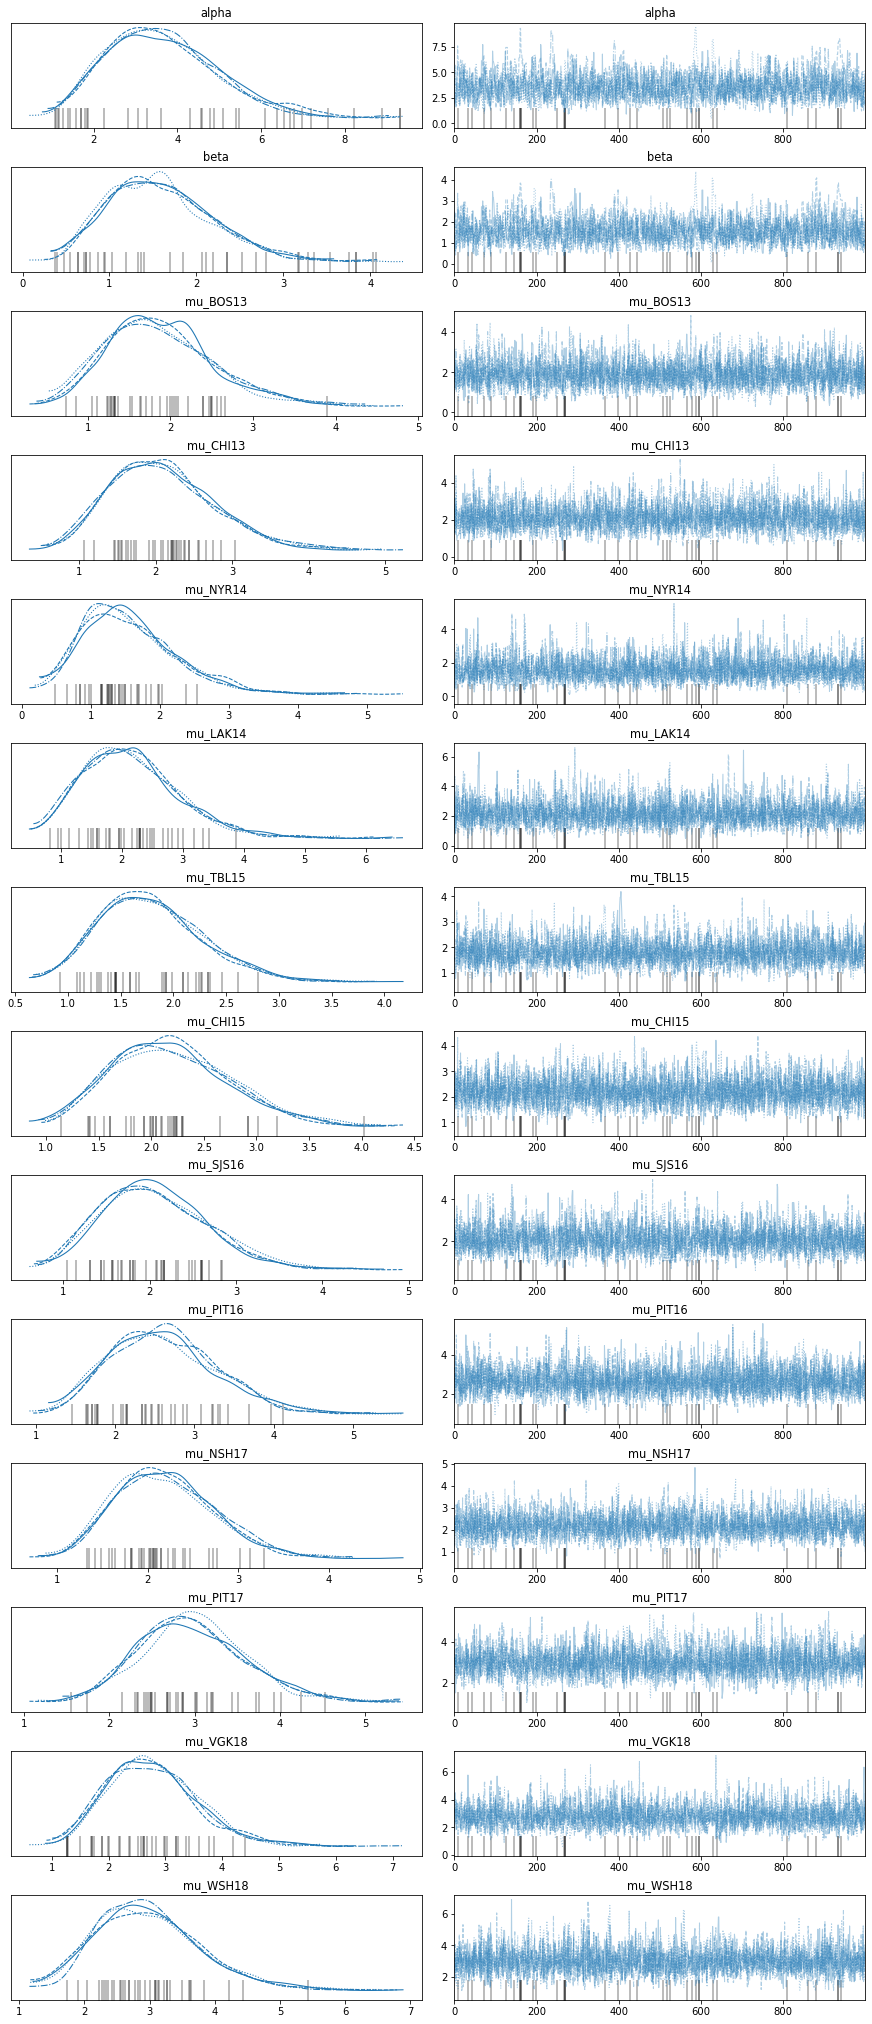

In [42]:
with model:
    az.plot_trace(trace);

Here are the posterior means.

In [94]:
sample_post_mu_VGK = trace['mu_VGK18']
np.mean(sample_post_mu_VGK)

2.738049580241473

In [95]:
sample_post_mu_WSH = trace['mu_WSH18']
np.mean(sample_post_mu_WSH)

2.9708625859213225

They are lower with the background information than without, and closer together.  Here's the updated chance that Vegas is the better team.

In [96]:
np.mean(sample_post_mu_VGK > sample_post_mu_WSH)

0.427